In [1]:
# CHANGED FOR TPU 1VM:
# Install the local TF wheel
!pip install /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -U tensorflow-addons
!pip install scikit-learn

Processing /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 62.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0.7
    Uninstalling flatbuffers-2.0.7:
      Successfully uninstalled flatbuffers-2.0.7
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tens

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    jaccard_score, classification_report
)

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE

tf.compat.v1.enable_eager_execution()
#dataset = dataset.with_options(options)  # use this as input for your model

print("Tensorflow version " + tf.__version__)

2022-12-27 16:39:52.797676: I tensorflow/core/tpu/tpu_api_dlsym_initializer.cc:116] Libtpu path is: libtpu.so
[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


Tensorflow version 2.9.1


In [3]:
# CHANGED FOR TPU 1VM:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local") # "local" for 1VM TPU
    strategy = tf.distribute.TPUStrategy(tpu)
except tf.errors.NotFoundError:
    strategy = tf.distribute.MirroredStrategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2022-12-27 16:40:02.778921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 16:40:06.267528: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x564fb8b99b10 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-27 16:40:06.267569: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): TPU, 2a886c8
2022-12-27 16:40:06.267579: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (1): TPU, 2a886c8
2022-12-27 16:40:06.267586: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (2): TPU, 2a886c8
2022-12-27 16:40:06.267594: I tensorflow/compiler/xla/service/service.cc:17

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
df = pd.read_csv("/kaggle/input/daphnet-dataset/data.csv").drop_duplicates()
df

,input0,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input759,input760,input761,input762,input763,input764,input765,input766,input767,label
0,-45.0,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,...,181.0,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,0.0
1,-18.0,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,...,202.0,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,0.0
2,18.0,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,...,202.0,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,0.0
3,36.0,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,...,171.0,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,0.0
4,36.0,27.0,27.0,-18.0,-90.0,-90.0,-136.0,-145.0,-163.0,-236.0,...,202.0,212.0,202.0,202.0,191.0,181.0,222.0,212.0,202.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116802,-109.0,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116803,-109.0,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116804,-109.0,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1116805,-109.0,-109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X = df.values[:, :-1]
X.shape

(1094288, 768)

In [6]:
y = df.label.astype(int).values
y

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 42)
X_train.shape

(875430, 768)

Abandoned Code:

```python
def img_process(X):
    X_img = X.reshape(-1, 3, 16, 16).transpose((0, 2, 3, 1))
    minval = X_img.min(axis=(1, 2)).reshape(-1, 1, 1, 3)
    maxval = X_img.max(axis=(1, 2)).reshape(-1, 1, 1, 3)
    X_img_norm = 255 * (X_img - minval) / (maxval - minval)
    return X_img_norm.astype(int)

X_train_img = img_process(X_train)
X_val_img = img_process(X_val)
X_test_img = img_process(X_test)
```

In [8]:
def train_fit_model(model):
    history = model.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), 
        epochs=50, validation_steps=100,
        steps_per_epoch=100
    )
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall"]):
        axes[i // 2, i % 2].plot(history.history[metric], label="Training")
        axes[i // 2, i % 2].plot(history.history["val_"+metric], label="Validation")    
        axes[i // 2, i % 2].set_title(metric.title())
        axes[i // 2, i % 2].legend()
    
    plt.show()
    
    curves = pd.DataFrame(history.history)
    
    h_test = model.predict(X_test).round().flatten()
    
    # Compile Values into a Series Object for easy display
    values = pd.Series({
        "Accuracy":accuracy_score(y_test, h_test),
        "Precision":precision_score(y_test, h_test),
        "Recall":recall_score(y_test, h_test),
        "F1 Score":f1_score(y_test, h_test),
        "Jaccard Score":jaccard_score(y_test, h_test),
    })
    
    report = pd.DataFrame(classification_report(y_test, h_test, output_dict=True)).T
    
    print(values)
    return model, curves, values, report

In [9]:
def pretrained_model(model_class):
    with strategy.scope():
        model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape = (768, 1)),
            tf.keras.layers.Dense(256*256*3, activation=tf.nn.swish),
            tf.keras.layers.Reshape((256, 256, 3)),
            model_class(input_shape=(256, 256, 3), include_top=False, weights='imagenet'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy', "Precision", "Recall", "AUC"])

        return model

In [10]:
def train_pretrained(model_class, model_name):
    model = pretrained_model(model_class)
    model.summary()
    model, curves, values, report = train_fit_model(model)

    os.mkdir(model_name)
    curves.to_csv(f"{model_name}/curves.csv", index=False)
    report.to_csv(f"{model_name}/report.csv")
    model.save_weights(f"{model_name}/model.h5")
    return report

2022-12-27 16:46:42.158578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-27 16:46:42.185595: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2022-12-27 16:46:42.221884: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:57] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. RandomUniform


4334752/4334752 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 196608)            151191552 
                                                                 
 reshape (Reshape)           (None, 256, 256, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 8, 8, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                           

2022-12-27 16:47:07.476095: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_16074"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUC

Epoch 1/50


2022-12-27 16:47:30.345318: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:254] Subgraph fingerprint:10848303091363282765
2022-12-27 16:47:31.610927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 16:47:32.840487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-27 16:47:34.651594: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(4774633227039765751), session_name()
2022-12-27 16:48:02.014535: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 4774633227039765751 with session name  took 27.362355117s and succeeded
2022-12-27 16:48:02.086928: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host 

 99/100 [============================>.] - ETA: 0s - loss: 0.2448 - accuracy: 0.9011 - precision: 0.5517 - recall: 0.1241 - auc: 0.8524

2022-12-27 16:48:49.148457: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(12912389397522902049), session_name()
2022-12-27 16:49:14.906309: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 12912389397522902049 with session name  took 25.757685924s and succeeded
2022-12-27 16:49:14.970475: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(12912389397522902049), session_name(), subgraph_key(std::string(property.function_name) = "cluster_train_function_10848303091363282765", property.function_library_fingerprint = 16595343544785008372, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(prop

100/100 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9012 - precision: 0.5532 - recall: 0.1248 - auc: 0.8530

2022-12-27 16:49:15.809351: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_41752"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:52"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODU

100/100 [==============================] - 148s 947ms/step - loss: 0.2445 - accuracy: 0.9012 - precision: 0.5532 - recall: 0.1248 - auc: 0.8530 - val_loss: 0.3604 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4795


2022-12-27 16:49:36.310969: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 8978391943704334408 with session name  took 6.488984304s and succeeded
2022-12-27 16:49:36.327328: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(8978391943704334408), session_name(), subgraph_key(std::string(property.function_name) = "cluster_test_function_5953630008614749132", property.function_library_fingerprint = 288013503263709208, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "128,768,;128,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 16:49:36.327387: I tensorflow/core/tp

Epoch 2/50
100/100 [==============================] - 51s 505ms/step - loss: 0.2012 - accuracy: 0.9131 - precision: 0.6609 - recall: 0.2916 - auc: 0.9132 - val_loss: 0.3496 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5841
Epoch 3/50
100/100 [==============================] - 51s 507ms/step - loss: 0.1849 - accuracy: 0.9197 - precision: 0.6929 - recall: 0.3723 - auc: 0.9289 - val_loss: 0.3330 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5728
Epoch 4/50
100/100 [==============================] - 51s 507ms/step - loss: 0.1711 - accuracy: 0.9257 - precision: 0.7196 - recall: 0.4362 - auc: 0.9405 - val_loss: 0.3290 - val_accuracy: 0.8977 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5204
Epoch 5/50
100/100 [==============================] - 51s 506ms/step - loss: 0.1551 - accuracy: 0.9332 - precision: 0.7483 - recall: 0.5123 - auc: 0.9521 - val_loss: 0.3346 - val_accuracy: 0.8977 - v

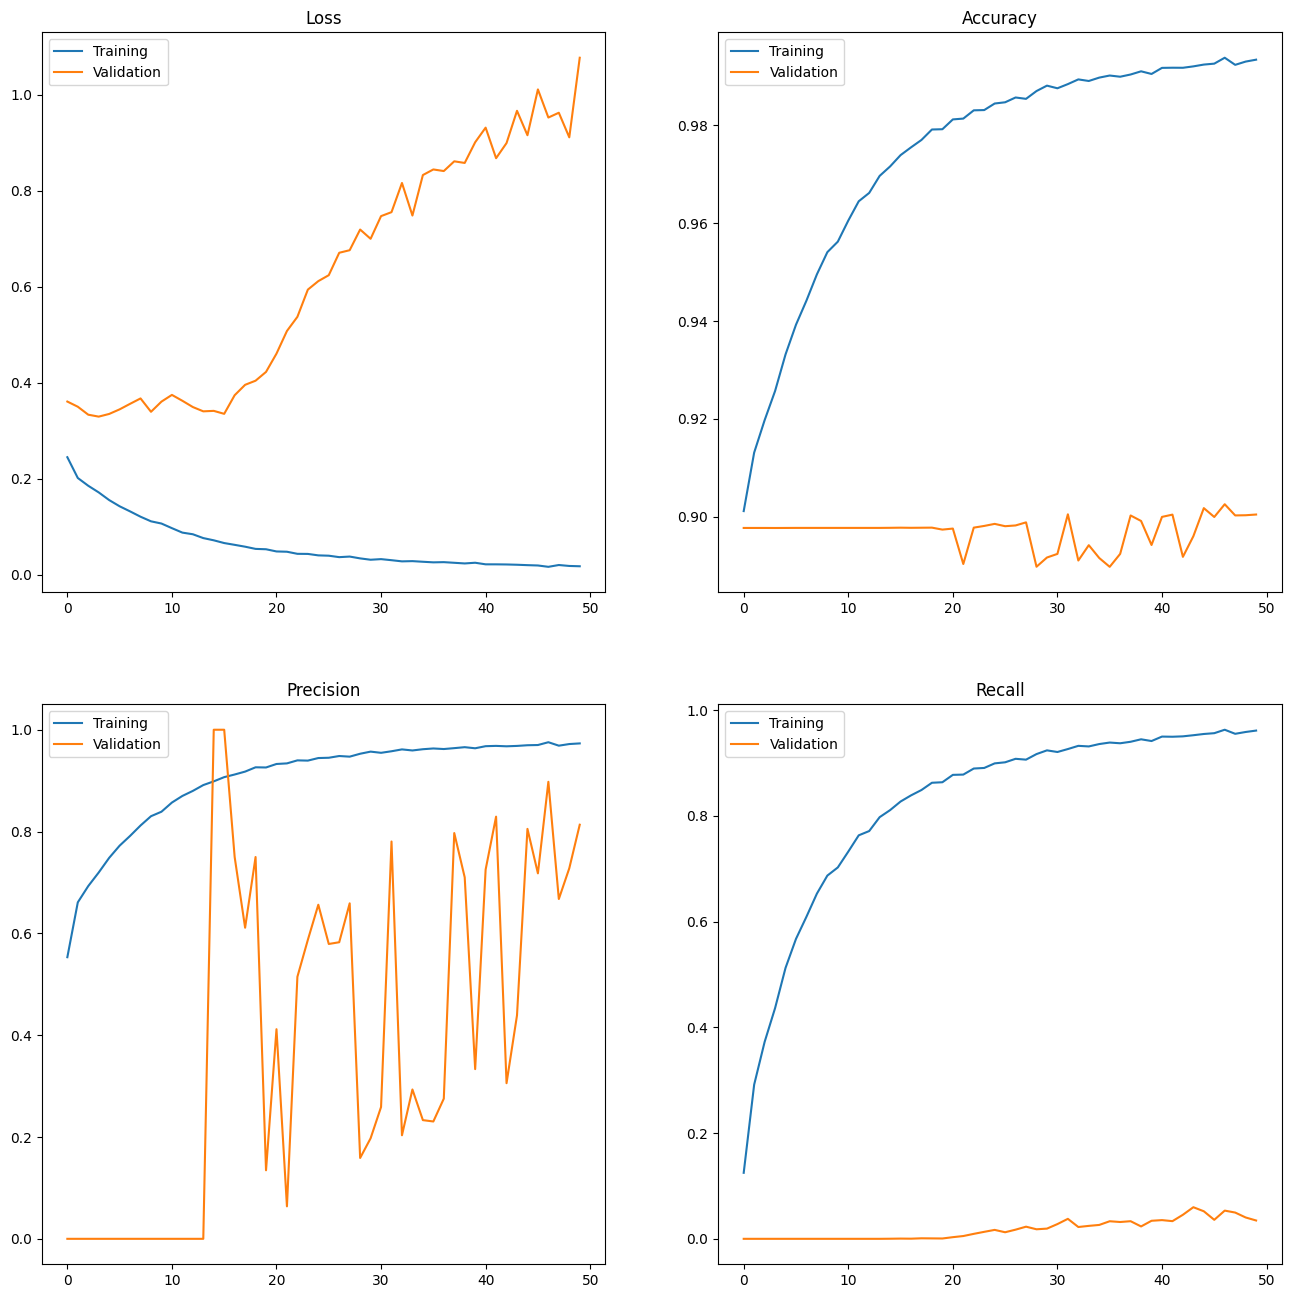

2022-12-27 17:31:01.015204: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_172746"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1662"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

   7/3420 [..............................] - ETA: 1:12

2022-12-27 17:33:04.244765: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 123555635250042998 with session name  took 2m0.004466244s and succeeded
2022-12-27 17:33:04.258063: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(123555635250042998), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_10751232383080461836", property.function_library_fingerprint = 3599494020331502778, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "4,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 17:33:04.258135: I tensorflow/core/tpu/

3418/3420 [============================>.] - ETA: 0s

2022-12-27 17:34:12.604466: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:435] TPU host compilation cache miss: cache_key(1717990256191233676), session_name()


3420/3420 [==============================] - 273s 44ms/step


2022-12-27 17:35:33.704667: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:193] Compilation of 1717990256191233676 with session name  took 1m21.100097659s and succeeded
2022-12-27 17:35:33.713581: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:468] TPU host compilation cache: compilation complete for cache_key(1717990256191233676), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_10751232383080461836", property.function_library_fingerprint = 3599494020331502778, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "3,768,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-27 17:35:33.713642: I tensorflow/core/t

Accuracy         0.903024
Precision        0.804143
Recall           0.039049
F1 Score         0.074481
Jaccard Score    0.038681
dtype: float64


,precision,recall,f1-score,support
0,0.903506,0.998944,0.948831,98494.000000
1,0.804143,0.039049,0.074481,10935.000000
accuracy,0.903024,0.903024,0.903024,0.903024
macro avg,0.853825,0.518997,0.511656,109429.000000
weighted avg,0.893577,0.903024,0.861459,109429.000000


In [11]:
train_pretrained(tf.keras.applications.MobileNetV3Small, "mobilenet_small")